In [3]:
import json, os, re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pickle as pkl
from math import log

In [5]:
with open("../EstimateTime/file_to_index.json", "r") as fp:
    file_index_dict = json.load(fp)

In [87]:
def get_size(extract_path, file_format_string):
	datapoints = []
	empty_files = 0
	for subdir, dirs, files, in os.walk(extract_path):
		for file in files:
			filepath = os.path.join(subdir, file)
			file_dict = json.load(open(filepath, "r"))
			idx = re.search(file_format_string, file).group(1)
			try:
				metadata_file_size = os.path.getsize(filepath)
				file_size = os.path.getsize(file_index_dict[idx])
				if file_size > 8 and metadata_file_size > 256:
					datapoints.append((file_size, metadata_file_size))
			except KeyError:
				empty_files += 1
	return datapoints

In [88]:
datapoints = get_size("../../../CDIACMetadataExtract/CDIACTabularExtracted", "TabXtract(.*).json")
print(len(datapoints)) 

5108


In [89]:
X = np.array([log(elem1) for elem1, elem2 in datapoints])
Y = np.array([log(elem2) for elem1, elem2 in datapoints])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1, 1)

In [90]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -4.162029 (0.329943)
ScaledLASSO: -4.169310 (0.337520)
ScaledEN: -4.169310 (0.337520)
ScaledKNN: -4.217792 (0.327874)
ScaledCART: -4.708804 (0.299328)
ScaledGBM: -3.911006 (0.335189)


In [93]:
model = GradientBoostingRegressor(random_state=42, n_estimators=400)
RegressionPipeline = Pipeline([('Scaler', StandardScaler()), ('Regression', model)])
RegressionPipeline.fit(X_train, Y_train)
predictions = RegressionPipeline.predict(X_test)
print (mean_squared_error(Y_test, predictions))

3.9194502205728736


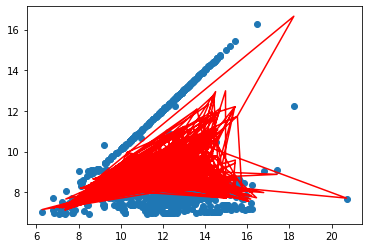

In [94]:
plt.scatter(X_test, Y_test)
plt.plot(X_test, predictions, color='red')
plt.show()

In [95]:
with open('models/TABULAR-GBR(Log X and Y).pkl', "wb+") as fp:
    pkl.dump(RegressionPipeline, fp)

In [27]:
print(RegressionPipeline['Regression'].get_params())

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}


In [30]:
mean = np.mean(Y)
print(mean)

5506.276923076923
